 Network Depth vs Width Tutorial Experiment
Testing architectures with ~5K parameters each

 Starting Network Depth vs Width Experiments

 Testing on Simple: Linearly Separable Circles
 Simple: Linearly Separable Circles - Deep & Narrow (Skyscraper): 1.000 accuracy, 2945 params
 Simple: Linearly Separable Circles - Shallow & Wide (Stadium): 1.000 accuracy, 513 params
 Simple: Linearly Separable Circles - Balanced (Office): 1.000 accuracy, 2305 params

 Testing on Moderate: Non-linear Moons
 Moderate: Non-linear Moons - Deep & Narrow (Skyscraper): 0.995 accuracy, 2945 params
 Moderate: Non-linear Moons - Shallow & Wide (Stadium): 0.985 accuracy, 513 params
 Moderate: Non-linear Moons - Balanced (Office): 0.990 accuracy, 2305 params

 Testing on Complex: High-Dimensional (3 classes)
 Complex: High-Dimensional (3 classes) - Deep & Narrow (Skyscraper): 0.995 accuracy, 9235 params
 Complex: High-Dimensional (3 classes) - Shallow & Wide (Stadium): 1.000 accuracy, 13315 params
 Complex: High-

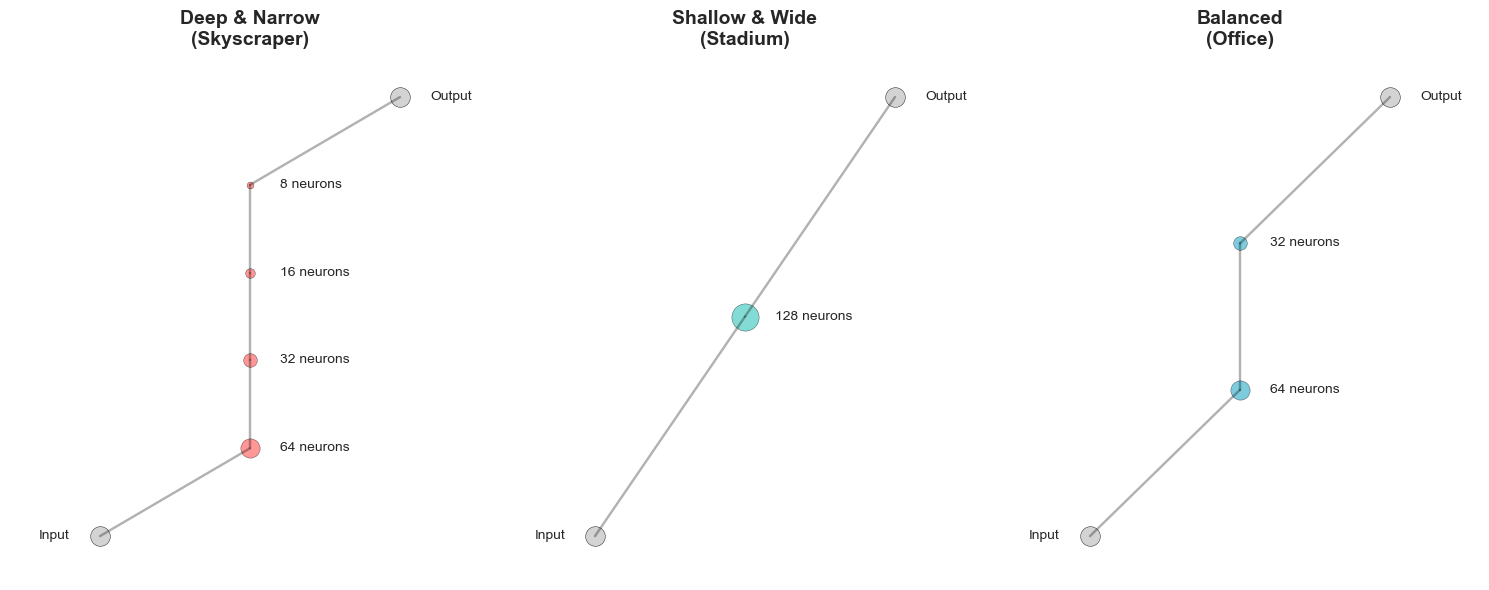

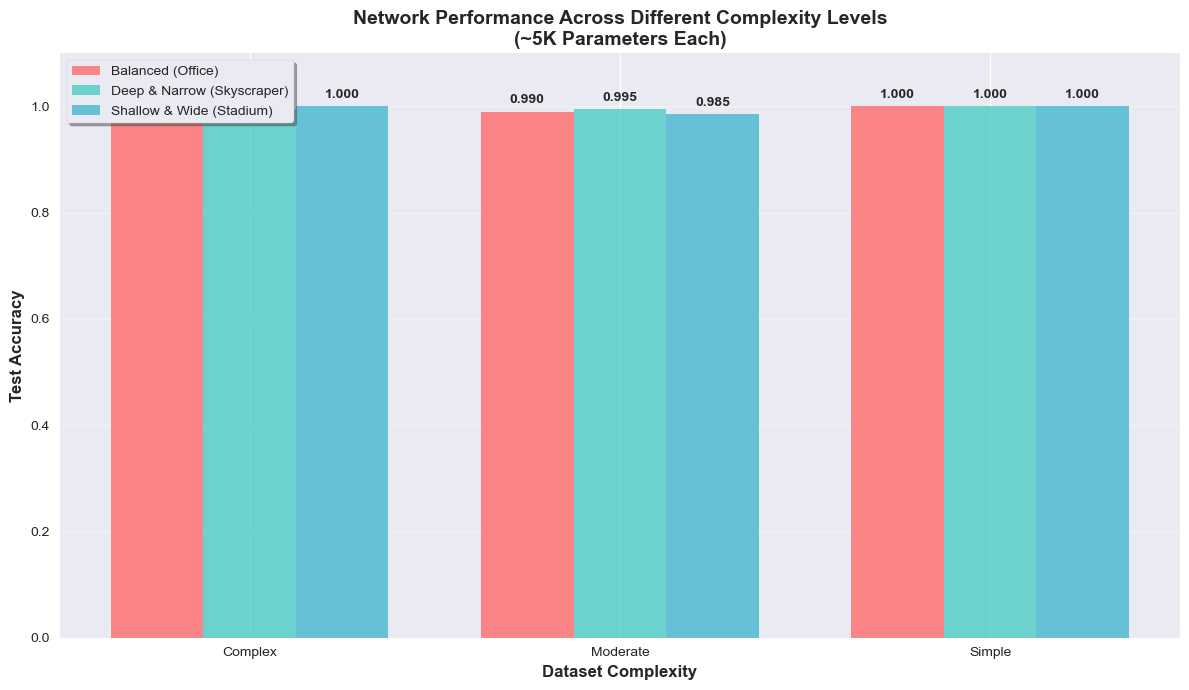

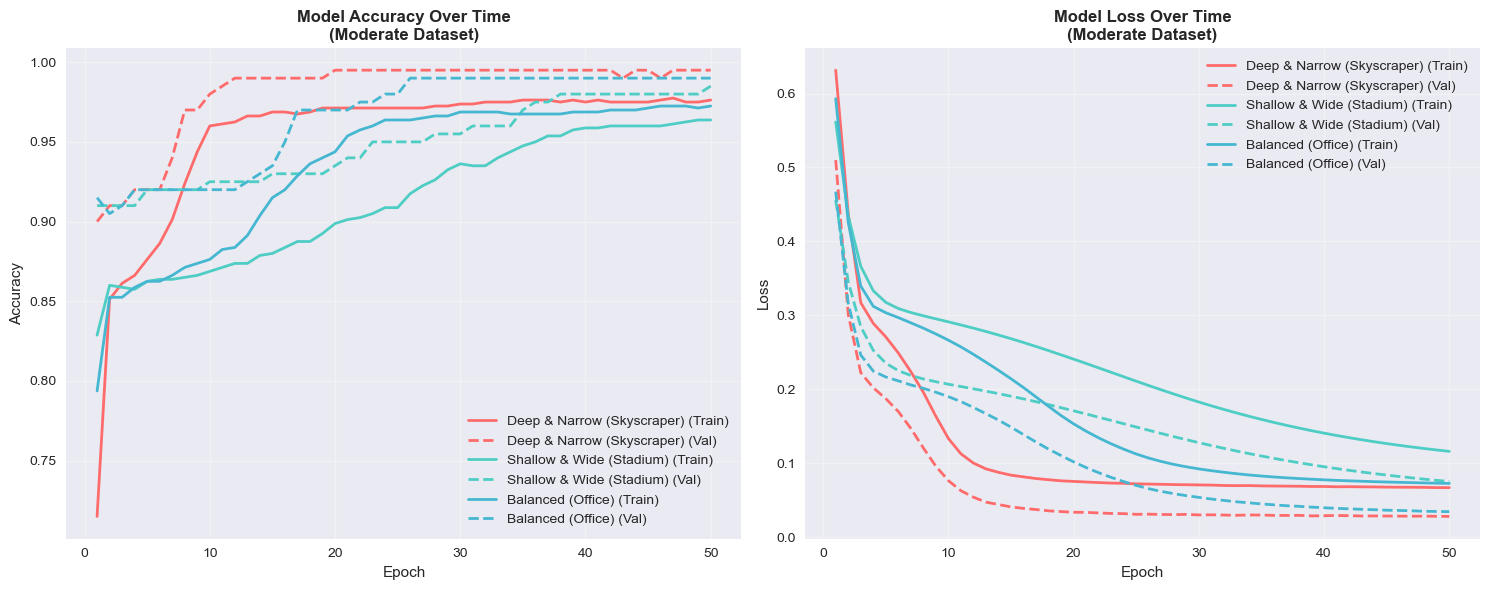


 Parameter Budget Summary
                           parameters test_accuracy        training_time
                                first          mean    std          mean
architecture                                                            
Balanced (Office)                2305         0.997  0.006         9.711
Deep & Narrow (Skyscraper)       2945         0.997  0.003        12.644
Shallow & Wide (Stadium)          513         0.995  0.009        10.996

 All visualizations saved!
Files created:
- architecture_comparison.png
- results_comparison.png
- training_curves.png

 Key Insights for Tutorial:
• Simple: Deep & Narrow (Skyscraper) wins (1.000 vs 1.000)
• Moderate: Deep & Narrow (Skyscraper) wins (0.995 vs 0.985)
• Complex: Shallow & Wide (Stadium) wins (1.000 vs 0.995)


In [7]:
"""
Network Depth vs Width Tutorial Experiments
==========================================

This code implements the "Parameter Budget Challenge" comparing:
- Deep & Narrow (Skyscraper): 64→32→16→8 layers
- Shallow & Wide (Stadium): 128 neurons single layer  
- Balanced (Office): 64→32 layers

Testing on 3 complexity levels:
1. Simple: Linearly separable circles
2. Moderate: Non-linear moons with noise
3. Complex: CIFAR-10 subset (3 classes)

All networks use ~5,000 parameters for fair comparison.
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_circles, make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time
import pandas as pd

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class NetworkArchitectures:
    """Defines the three network architectures with ~5K parameters each"""
    
    @staticmethod
    def count_parameters(model):
        """Count total parameters in a model"""
        return model.count_params()
    
    @staticmethod
    def create_deep_narrow(input_dim, num_classes):
        """Deep & Narrow: The Skyscraper (64→32→16→8)"""
        output_units = 1 if num_classes == 2 else num_classes
        output_activation = 'sigmoid' if num_classes == 2 else 'softmax'
        
        model = keras.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(16, activation='relu'),
            layers.Dense(8, activation='relu'),
            layers.Dense(output_units, activation=output_activation)
        ])
        return model
    
    @staticmethod
    def create_shallow_wide(input_dim, num_classes):
        """Shallow & Wide: The Stadium (128)"""
        output_units = 1 if num_classes == 2 else num_classes
        output_activation = 'sigmoid' if num_classes == 2 else 'softmax'
        
        model = keras.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Dense(128, activation='relu'),
            layers.Dense(output_units, activation=output_activation)
        ])
        return model
    
    @staticmethod
    def create_balanced(input_dim, num_classes):
        """Balanced: The Office Building (64→32)"""
        output_units = 1 if num_classes == 2 else num_classes
        output_activation = 'sigmoid' if num_classes == 2 else 'softmax'
        
        model = keras.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(output_units, activation=output_activation)
        ])
        return model

class DatasetGenerator:
    """Generates the three complexity levels of datasets"""
    
    @staticmethod
    def create_simple_dataset(n_samples=1000):
        """Level 1: Simple linearly separable circles"""
        X, y = make_circles(n_samples=n_samples, factor=0.3, noise=0.05, random_state=42)
        return X, y, "Simple: Linearly Separable Circles"
    
    @staticmethod
    def create_moderate_dataset(n_samples=1000):
        """Level 2: Moderate non-linear moons with noise"""
        X, y = make_moons(n_samples=n_samples, noise=0.2, random_state=42)
        return X, y, "Moderate: Non-linear Moons"
    
    @staticmethod
    def create_complex_dataset(n_samples=1000):
        """Level 3: Complex high-dimensional synthetic dataset (3 classes)"""
        np.random.seed(42)  # For reproducibility
        
        # Create 3 complex, overlapping clusters in high-dimensional space
        n_features = 100  # High-dimensional to make it challenging
        n_per_class = n_samples // 3
        
        # Class 0: Centered around origin with some spread
        X_class0 = np.random.normal(0, 1, (n_per_class, n_features))
        # Add some non-linear structure
        X_class0[:, :20] = X_class0[:, :20] ** 2 * np.sign(X_class0[:, :20])
        
        # Class 1: Shifted and rotated
        X_class1 = np.random.normal(2, 1.5, (n_per_class, n_features))
        # Add sinusoidal patterns
        for i in range(10):
            X_class1[:, i] += 0.5 * np.sin(X_class1[:, i+10])
        
        # Class 2: Ring-like structure in first few dimensions, noise in others
        X_class2 = np.random.normal(-1, 1, (n_per_class, n_features))
        # Create ring pattern in first 10 dimensions
        angles = np.random.uniform(0, 2*np.pi, n_per_class)
        radius = np.random.normal(3, 0.5, n_per_class)
        X_class2[:, 0] = radius * np.cos(angles)
        X_class2[:, 1] = radius * np.sin(angles)
        
        # Combine all classes
        X = np.vstack([X_class0, X_class1, X_class2])
        y = np.hstack([np.zeros(n_per_class), np.ones(n_per_class), np.full(n_per_class, 2)])
        
        # Add some noise to make it more challenging
        X += np.random.normal(0, 0.1, X.shape)
        
        # Shuffle the data
        indices = np.random.permutation(len(X))
        X, y = X[indices], y[indices]
        
        # Ensure we have exactly n_samples
        X, y = X[:n_samples], y[:n_samples]
        
        return X.astype('float32'), y.astype('int'), "Complex: High-Dimensional (3 classes)"

class ExperimentRunner:
    """Runs the experiments and collects results"""
    
    def __init__(self):
        self.results = []
        self.training_histories = {}
        
    def run_single_experiment(self, X, y, dataset_name, architecture_name, model_creator, input_dim):
        """Run a single experiment configuration"""
        
        # Determine number of classes
        num_classes = len(np.unique(y))
        binary_classification = num_classes == 2
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Create and compile model
        model = model_creator(input_dim, num_classes)
        
        if binary_classification:
            model.compile(
                optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy']
            )
        else:
            model.compile(
                optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy']
            )
        
        # Train model
        start_time = time.time()
        history = model.fit(
            X_train_scaled, y_train,
            batch_size=32,
            epochs=50,
            validation_data=(X_test_scaled, y_test),
            verbose=0
        )
        training_time = time.time() - start_time
        
        # Evaluate
        test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
        
        # Store results
        result = {
            'dataset': dataset_name,
            'architecture': architecture_name,
            'test_accuracy': test_accuracy,
            'training_time': training_time,
            'parameters': model.count_params(),
            'final_val_loss': history.history['val_loss'][-1]
        }
        
        self.results.append(result)
        
        # Store history for interesting cases (moderate dataset)
        if "Moderate" in dataset_name:
            self.training_histories[architecture_name] = history.history
        
        print(f" {dataset_name} - {architecture_name}: {test_accuracy:.3f} accuracy, {model.count_params()} params")
        
        return result
    
    def run_all_experiments(self):
        """Run the complete experimental suite"""
        
        print(" Starting Network Depth vs Width Experiments")
        print("=" * 50)
        
        # Define architectures
        architectures = [
            ("Deep & Narrow (Skyscraper)", NetworkArchitectures.create_deep_narrow),
            ("Shallow & Wide (Stadium)", NetworkArchitectures.create_shallow_wide),
            ("Balanced (Office)", NetworkArchitectures.create_balanced)
        ]
        
        # Generate datasets
        datasets = [
            DatasetGenerator.create_simple_dataset(),
            DatasetGenerator.create_moderate_dataset(),
            DatasetGenerator.create_complex_dataset()
        ]
        
        # Run all combinations
        for X, y, dataset_name in datasets:
            print(f"\n Testing on {dataset_name}")
            input_dim = X.shape[1]
            
            for arch_name, arch_creator in architectures:
                self.run_single_experiment(
                    X, y, dataset_name, arch_name, arch_creator, input_dim
                )
        
        print(f"\n All experiments completed!")
        return self.results

class ResultsVisualizer:
    """Creates visualizations for the tutorial slides"""
    
    def __init__(self, results, training_histories):
        self.results = pd.DataFrame(results)
        self.training_histories = training_histories
        
    def create_architecture_diagram(self):
        """Create diagram showing the three architectures"""
        fig, axes = plt.subplots(1, 3, figsize=(15, 6))
        
        # Architecture specifications
        architectures = [
            {"name": "Deep & Narrow\n(Skyscraper)", "layers": [64, 32, 16, 8], "color": "#FF6B6B"},
            {"name": "Shallow & Wide\n(Stadium)", "layers": [128], "color": "#4ECDC4"},
            {"name": "Balanced\n(Office)", "layers": [64, 32], "color": "#45B7D1"}
        ]
        
        for i, arch in enumerate(architectures):
            ax = axes[i]
            
            # Draw network layers
            layer_positions = np.linspace(0, 1, len(arch["layers"]) + 2)
            
            # Input layer
            ax.scatter([0], [layer_positions[0]], s=200, c='lightgray', edgecolors='black')
            ax.text(-0.1, layer_positions[0], 'Input', ha='right', va='center')
            
            # Hidden layers
            for j, neurons in enumerate(arch["layers"]):
                y_pos = layer_positions[j + 1]
                ax.scatter([0.5], [y_pos], s=neurons*3, c=arch["color"], alpha=0.7, edgecolors='black')
                ax.text(0.6, y_pos, f'{neurons} neurons', ha='left', va='center')
            
            # Output layer
            ax.scatter([1], [layer_positions[-1]], s=200, c='lightgray', edgecolors='black')
            ax.text(1.1, layer_positions[-1], 'Output', ha='left', va='center')
            
            # Connect layers with lines
            for j in range(len(layer_positions) - 1):
                ax.plot([0, 0.5] if j == 0 else [0.5, 0.5] if j < len(layer_positions) - 2 else [0.5, 1], 
                       [layer_positions[j], layer_positions[j+1]], 'k-', alpha=0.3)
            
            ax.set_xlim(-0.3, 1.3)
            ax.set_ylim(-0.1, 1.1)
            ax.set_title(arch["name"], fontsize=14, fontweight='bold')
            ax.axis('off')
        
        plt.tight_layout()
        plt.savefig('architecture_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
        
    def create_results_comparison(self):
        """Create bar chart comparing results across datasets and architectures"""
        
        # Pivot data for plotting
        pivot_data = self.results.pivot(index='dataset', columns='architecture', values='test_accuracy')
        
        # Create grouped bar chart
        fig, ax = plt.subplots(figsize=(12, 7))
        
        # Define colors for architectures
        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
        
        # Create bars
        x = np.arange(len(pivot_data.index))
        width = 0.25
        
        for i, (arch, color) in enumerate(zip(pivot_data.columns, colors)):
            bars = ax.bar(x + i*width, pivot_data[arch], width, label=arch, color=color, alpha=0.8)
            
            # Add value labels on bars
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{height:.3f}', ha='center', va='bottom', fontweight='bold')
        
        # Customize plot
        ax.set_xlabel('Dataset Complexity', fontsize=12, fontweight='bold')
        ax.set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
        ax.set_title('Network Performance Across Different Complexity Levels\n(~5K Parameters Each)', 
                    fontsize=14, fontweight='bold')
        ax.set_xticks(x + width)
        ax.set_xticklabels([name.split(':')[0] for name in pivot_data.index])
        ax.legend(loc='upper left', frameon=True, fancybox=True, shadow=True)
        ax.grid(axis='y', alpha=0.3)
        ax.set_ylim(0, 1.1)
        
        plt.tight_layout()
        plt.savefig('results_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
        
    def create_training_curves(self):
        """Create training curves for the moderate dataset"""
        
        if not self.training_histories:
            print("No training histories available")
            return
            
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
        
        # Plot training curves
        for i, (arch_name, history) in enumerate(self.training_histories.items()):
            epochs = range(1, len(history['accuracy']) + 1)
            
            # Accuracy subplot
            ax1.plot(epochs, history['accuracy'], label=f'{arch_name} (Train)', 
                    color=colors[i], linestyle='-', linewidth=2)
            ax1.plot(epochs, history['val_accuracy'], label=f'{arch_name} (Val)', 
                    color=colors[i], linestyle='--', linewidth=2)
            
            # Loss subplot  
            ax2.plot(epochs, history['loss'], label=f'{arch_name} (Train)', 
                    color=colors[i], linestyle='-', linewidth=2)
            ax2.plot(epochs, history['val_loss'], label=f'{arch_name} (Val)', 
                    color=colors[i], linestyle='--', linewidth=2)
        
        # Customize accuracy plot
        ax1.set_title('Model Accuracy Over Time\n(Moderate Dataset)', fontweight='bold')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Customize loss plot
        ax2.set_title('Model Loss Over Time\n(Moderate Dataset)', fontweight='bold')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
        plt.show()
        
    def create_parameter_summary(self):
        """Create summary table of parameters for each architecture"""
        
        param_summary = self.results.groupby('architecture').agg({
            'parameters': 'first',  # All same architecture have same params
            'test_accuracy': ['mean', 'std'],
            'training_time': 'mean'
        }).round(3)
        
        print("\n Parameter Budget Summary")
        print("=" * 40)
        print(param_summary)
        
        return param_summary

def main():
    """Main execution function"""
    
    print(" Network Depth vs Width Tutorial Experiment")
    print("Testing architectures with ~5K parameters each\n")
    
    # Run experiments
    runner = ExperimentRunner()
    results = runner.run_all_experiments()
    
    # Create visualizations
    visualizer = ResultsVisualizer(results, runner.training_histories)
    
    print("\n Creating visualizations for tutorial slides...")
    
    # Generate all plots
    visualizer.create_architecture_diagram()
    visualizer.create_results_comparison()
    visualizer.create_training_curves()
    param_summary = visualizer.create_parameter_summary()
    
    print("\n All visualizations saved!")
    print("Files created:")
    print("- architecture_comparison.png")
    print("- results_comparison.png") 
    print("- training_curves.png")
    
    # Print key insights for tutorial
    print("\n Key Insights for Tutorial:")
    results_df = pd.DataFrame(results)
    
    for dataset in results_df['dataset'].unique():
        dataset_results = results_df[results_df['dataset'] == dataset]
        best_arch = dataset_results.loc[dataset_results['test_accuracy'].idxmax(), 'architecture']
        best_acc = dataset_results['test_accuracy'].max()
        worst_acc = dataset_results['test_accuracy'].min()
        
        print(f"• {dataset.split(':')[0]}: {best_arch} wins ({best_acc:.3f} vs {worst_acc:.3f})")
    
    return results, visualizer

if __name__ == "__main__":
    results, visualizer = main()